In [1]:
import numpy as np
import numpy.random as npr
import torch
from torch.nn import functional as F
from torch.distributions.normal import Normal
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
import matplotlib.pyplot as pt
import copy
from tqdm import tqdm

from variational_dense import *
from fcnn import *

In [2]:
def generate_data(n_data, x_min, x_max, noise):
    x = np.linspace(x_min, x_max, n_data)
    #x1 = np.sort(npr.rand(n_data)*(x_max-x_min)+x_min)
    y1 = np.sin(x)+npr.randn(n_data)*noise
    #x2 = np.sort(npr.rand(n_data)*(x_max-x_min)+x_min)
    y2 = np.sin(x)+npr.randn(n_data)*noise
    return x, y1, y2

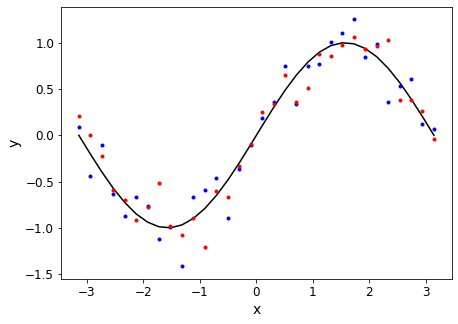

In [3]:
n_data = 32
x_min = -np.pi
x_max = np.pi
noise = 0.2

npr.seed(1234)
x, y1, y2 = generate_data(n_data, x_min, x_max, noise)

x_theo = np.arange(n_data)/(n_data-1)*(x_max-x_min)+x_min
y_theo = np.sin(x_theo)

fontsize = 14

pt.figure(1, figsize=(7, 5))
pt.xlabel('x', fontsize=fontsize)
pt.ylabel('y', fontsize=fontsize)
pt.tick_params(axis='both', labelsize=fontsize-2)
pt.plot(x_theo, y_theo, 'k-')
pt.plot(x, y1, 'b.')
pt.plot(x, y2, 'r.')
pt.show()

In [4]:
def fit_fcnn_nonlinear(x, y1, y2, hidden_neurons=[], lr_min=1e-5, lr_max=1e-3,
                       n_batch=1, n_epoch=100):

    model = FCNN(input_neuron=x.shape[1],
                 output_neuron=1,
                 hidden_neurons=hidden_neurons)
    
    x_train = torch.from_numpy(x.astype(np.float32))
    y_train = torch.from_numpy(y1.astype(np.float32)).view(-1, 1)
    y_valid = torch.from_numpy(y2.astype(np.float32)).view(-1, 1)

    n_data = x_train.size()[0]
    n_step = np.int(np.ceil(n_data/n_batch))
    
    optimizer = Adam(model.parameters(), lr=lr_min)
    scheduler = CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max,
                         step_size_up=1000, cycle_momentum=False)

    mse_valid_min = np.inf
    mse_train_history = []
    mse_valid_history = []
    for j in tqdm(range(n_epoch)):
        idx = npr.choice(n_data, n_data, replace=False)
        for i in range(n_step):
            idx_batch = idx[i*n_batch:(i+1)*n_batch]
            x_batch = x_train[idx_batch]
            y_train_batch = y_train[idx_batch]
            y_valid_batch = y_valid[idx_batch]
            
            model.train(True)
            yhat_batch = model(x_batch)
            mse_train = torch.mean((yhat_batch-y_train_batch)**2)
            mse_valid = torch.mean((yhat_batch-y_valid_batch)**2)

            mse_train_history.append(mse_train.item())
            mse_valid_history.append(mse_valid.item())
            if mse_valid_history[-1]<mse_valid_min:
                best_valid_model = copy.deepcopy(model)
                mse_valid_min = mse_valid_history[-1]

            optimizer.zero_grad()
            mse_train.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e5)
            optimizer.step()
            scheduler.step()

    return best_valid_model, model, mse_train_history, mse_valid_history

In [5]:
lr_min = 1e-5
lr_max = 1e-3
n_epoch = 8000

n_batch = n_data
best_valid_model, last_model, mse_train_history, mse_valid_history = \
fit_fcnn_nonlinear(x.reshape(-1, 1), y1, y2,
                   hidden_neurons=[4, 4],
                   lr_min=lr_min, lr_max=lr_max,
                   n_batch=n_batch, n_epoch=n_epoch)

100%|██████████| 8000/8000 [00:23<00:00, 336.93it/s]


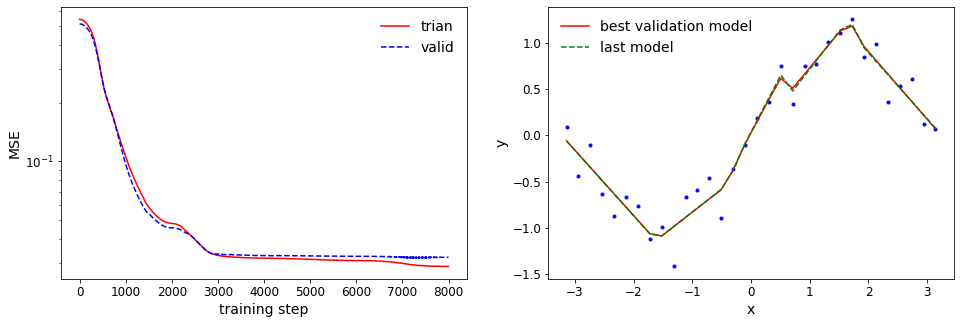

In [6]:
fontsize = 14

pt.figure(1, figsize=(16, 5))
pt.subplot(1, 2, 1)
pt.yscale('log')
pt.xlabel('training step', fontsize=fontsize)
pt.ylabel('MSE', fontsize=fontsize)
pt.tick_params(axis='both', labelsize=fontsize-2)
pt.plot(np.arange(len(mse_train_history)), mse_train_history, 'r-', label='trian')
pt.plot(np.arange(len(mse_valid_history)), mse_valid_history, 'b--', label='valid')
pt.legend(loc='upper right', frameon=False, fontsize=fontsize)

pt.subplot(1, 2, 2)
pt.xlabel('x', fontsize=fontsize)
pt.ylabel('y', fontsize=fontsize)
pt.tick_params(axis='both', labelsize=fontsize-2)
pt.plot(x, y1, 'b.')
yhat = best_valid_model(torch.from_numpy(x.reshape(-1, 1).astype(np.float32)))
pt.plot(x, yhat.detach().numpy(), 'r-', label='best validation model')
yhat = last_model(torch.from_numpy(x.reshape(-1, 1).astype(np.float32)))
pt.plot(x, yhat.detach().numpy(), 'g--', label='last model')
pt.legend(loc='upper left', frameon=False, fontsize=fontsize)

pt.show()

In [7]:
def fit_variational_nonlinear(x, y1, y2, y_noise, hidden_neurons=[],
                              Lambda=0, init_sigma=0.5, lr_min=1e-3, lr_max=1e-1,
                              n_batch=1, n_epoch=100):
    
    model = VariationalDense(in_features=x.shape[1],
                             out_features=1,
                             hidden_features=hidden_neurons,
                             init_sigma=init_sigma)
    
    x_train = torch.from_numpy(x.astype(np.float32))
    y_train = torch.from_numpy(y1.astype(np.float32)).view(-1, 1)
    y_valid = torch.from_numpy(y2.astype(np.float32)).view(-1, 1)

    n_data = x_train.size()[0]
    n_step = np.int(np.ceil(n_data/n_batch))
    
    optimizer = Adam(model.parameters(), lr=lr_min)
    scheduler = CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max,
                         step_size_up=1000, cycle_momentum=False)

    if Lambda>0:
        norm_prior = Normal(loc=0, scale=np.sqrt(1/Lambda))
    
    mse_valid_min = np.inf
    mse_train_history = []
    mse_valid_history = []
    for j in tqdm(range(n_epoch)):
        idx = npr.choice(n_data, n_data, replace=False)
        for i in range(n_step):
            idx_batch = idx[i*n_batch:(i+1)*n_batch]
            x_batch = x_train[idx_batch]
            y_train_batch = y_train[idx_batch]
            y_valid_batch = y_valid[idx_batch]
            
            model.train(True)
            yhat_batch, params_batch_list = model(x_batch)

            norm_y_batch = Normal(loc=y_train_batch, scale=y_noise)
            log_likelihood = torch.mean(norm_y_batch.log_prob(yhat_batch))*n_data

            log_varia_prob = 0
            for params_batch in params_batch_list:
                norm_W = Normal(loc=params_batch[0], scale=params_batch[1])
                norm_b = Normal(loc=params_batch[3], scale=params_batch[4])
                log_varia_prob += (torch.sum(norm_W.log_prob(params_batch[2]))
                                  +torch.sum(norm_b.log_prob(params_batch[5])))
                
            loss = log_varia_prob-log_likelihood

            if Lambda>0:
                for params_batch in params_batch_list:
                    log_prior = torch.sum(norm_prior.log_prob(params_batch[2]))
                    loss -= log_prior
                    
            mse_train_history.append(torch.mean((yhat_batch-y_train_batch)**2).item())
            mse_valid_history.append(torch.mean((yhat_batch-y_valid_batch)**2).item())
            if mse_valid_history[-1]<mse_valid_min:
                best_valid_model = copy.deepcopy(model)
                mse_valid_min = mse_valid_history[-1]

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e5)
            optimizer.step()
            scheduler.step()

    return best_valid_model, model, mse_train_history, mse_valid_history

In [8]:
y_true = np.sin(x)
noise_obs = np.std(y1-y_true, ddof=1)
#print(noise, noise_obs)

lr_min = 1e-5
lr_max = 1e-3
init_sigma = 0.5
n_epoch = 8000

n_batch = n_data
best_valid_model, last_model, mse_train_history, mse_valid_history = \
fit_variational_nonlinear(x.reshape(-1, 1),
                          y1, y2, y_noise=noise_obs,
                          hidden_neurons=[4, 4],
                          Lambda=0, init_sigma=init_sigma,
                          lr_min=lr_min, lr_max=lr_max,
                          n_batch=n_batch, n_epoch=n_epoch)

100%|██████████| 8000/8000 [00:53<00:00, 150.06it/s]


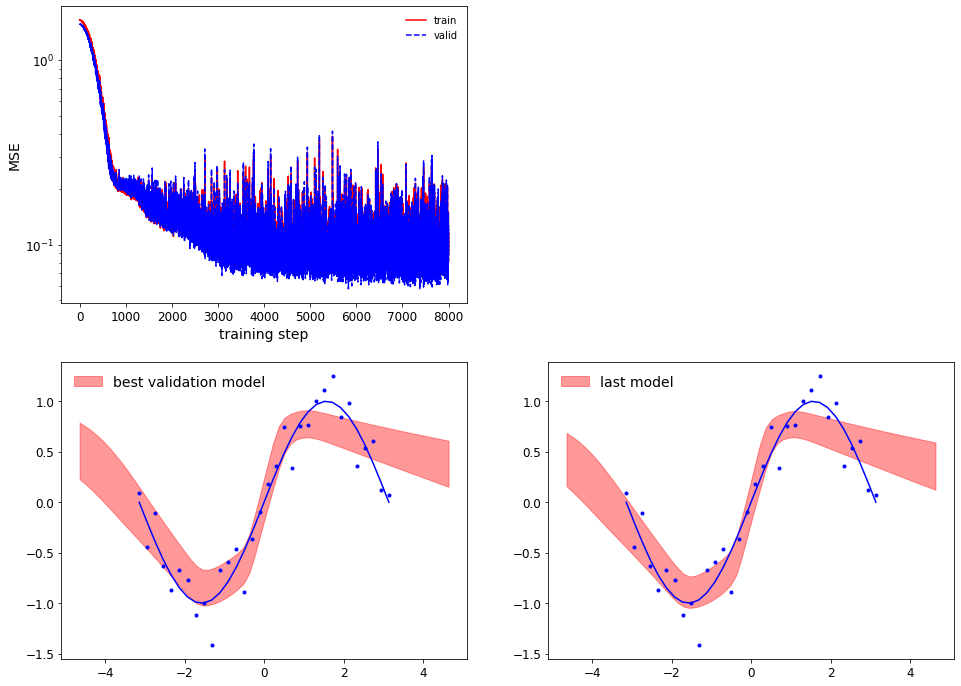

In [9]:
fontsize = 14
x_extend = np.linspace(-np.pi-1.5, np.pi+1.5, 64)

pt.figure(1, figsize=(16, 12))

pt.subplot(2, 2, 1)
pt.yscale('log')
pt.xlabel('training step', fontsize=fontsize)
pt.ylabel('MSE', fontsize=fontsize)
pt.tick_params(axis='both', labelsize=fontsize-2)
pt.plot(np.arange(len(mse_train_history)), mse_train_history, 'r-', label='train')
pt.plot(np.arange(len(mse_valid_history)), mse_valid_history, 'b--', label='valid')
pt.legend(loc='upper right', frameon=False)

pt.subplot(2, 2, 3)
pt.tick_params(axis='both', labelsize=fontsize-2)
yhat_best_model = []
for _ in range(1000):
    yhat, _ = best_valid_model(torch.from_numpy(x_extend.reshape(-1, 1).astype(np.float32)))
    yhat_best_model.append(yhat.detach().numpy().squeeze())
yhat_best_model = np.array(yhat_best_model)
yhat_best_model_mean = np.mean(yhat_best_model, axis=0)
yhat_best_model_std = np.std(yhat_best_model, axis=0, ddof=1)
pt.fill_between(x_extend,
                yhat_best_model_mean-yhat_best_model_std,
                yhat_best_model_mean+yhat_best_model_std,
                color='r', alpha=0.4, label='best validation model')
pt.plot(x, y1, 'b.')
pt.plot(x, np.sin(x), 'b-')
pt.legend(loc='upper left', frameon=False, fontsize=fontsize)

pt.subplot(2, 2, 4)
pt.tick_params(axis='both', labelsize=fontsize-2)
yhat_last_model = []
for _ in range(1000):
    yhat, _ = last_model(torch.from_numpy(x_extend.reshape(-1, 1).astype(np.float32)))
    yhat_last_model.append(yhat.detach().numpy().squeeze())
yhat_last_model = np.array(yhat_last_model)
yhat_last_model_mean = np.mean(yhat_last_model, axis=0)
yhat_last_model_std = np.std(yhat_last_model, axis=0, ddof=1)
pt.fill_between(x_extend,
                yhat_last_model_mean-yhat_last_model_std,
                yhat_last_model_mean+yhat_last_model_std,
                color='r', alpha=0.4, label='last model')
pt.plot(x, y1, 'b.')
pt.plot(x, np.sin(x), 'b-')
pt.legend(loc='upper left', frameon=False, fontsize=fontsize)

pt.show()